In [31]:
# imports

import pandas as pd
import numpy as np

import re
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns 

In [26]:
# load data

loans = pd.read_csv('Original_data/loans.csv', low_memory=False)


## Change object columns to numeric or string to visualized

In [27]:
# extract digits using regex and convert to int
loans['term'] = loans['term'].str.extract(r'(\d+)').astype(int)

# convert object into date
loans['issue_date'] = pd.to_datetime(loans['issue_date'] , format='%b-%Y')

# extract digits using regex and convert to int
def get_gbp (text):
    return re.sub (r'^GBP\s+', '', str(text))
loans['annual_income'] = loans['annual_income'].map(get_gbp).astype(float)

# extract digits using regex and convert to int

loans['employment_length'] = (
    loans['employment_length']
        .replace('< 1 year', '0.5 years')
        .replace('10+ years', '10 years')
        .str.extract(r'(\d+\.?\d*)')        # extract number
        .astype(float) * 12                 # convert years → months
)

loans['employment_length'] = loans['employment_length'].fillna(0)

## Visualization

### Loan status 

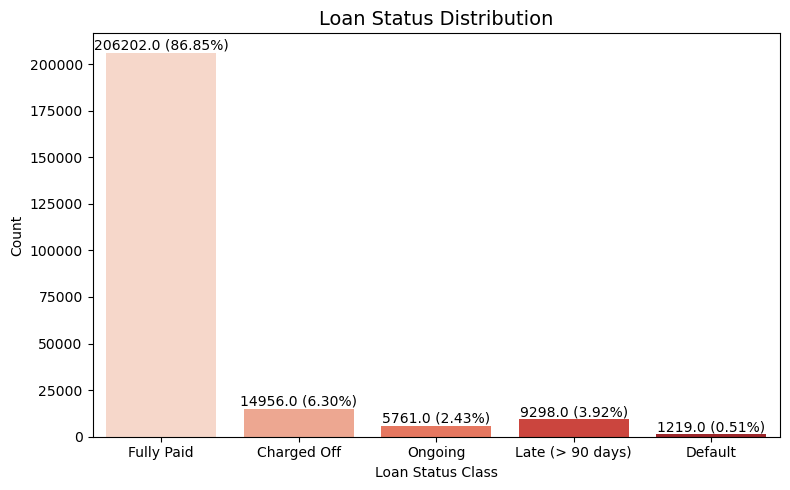

In [36]:
# Loan status 

counts = loans['loan_status'].value_counts()
percent = (counts / len(loans) * 100).round(2)


plt.figure(figsize=(8,5))
ax = sns.countplot(
    data=loans,
    x='loan_status',
    hue='loan_status',    
    palette='Reds',
    legend=False              # hide legend (not needed)
)

# Add labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    label = f"{height} ({height/len(data)*100:.2f}%)"
    ax.annotate(
        label,
        (p.get_x() + p.get_width() / 2., height),
        ha='center', va='bottom', fontsize=10
    )

plt.title("Loan Status Distribution", fontsize=14)
plt.xlabel("Loan Status Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



### Heatmap

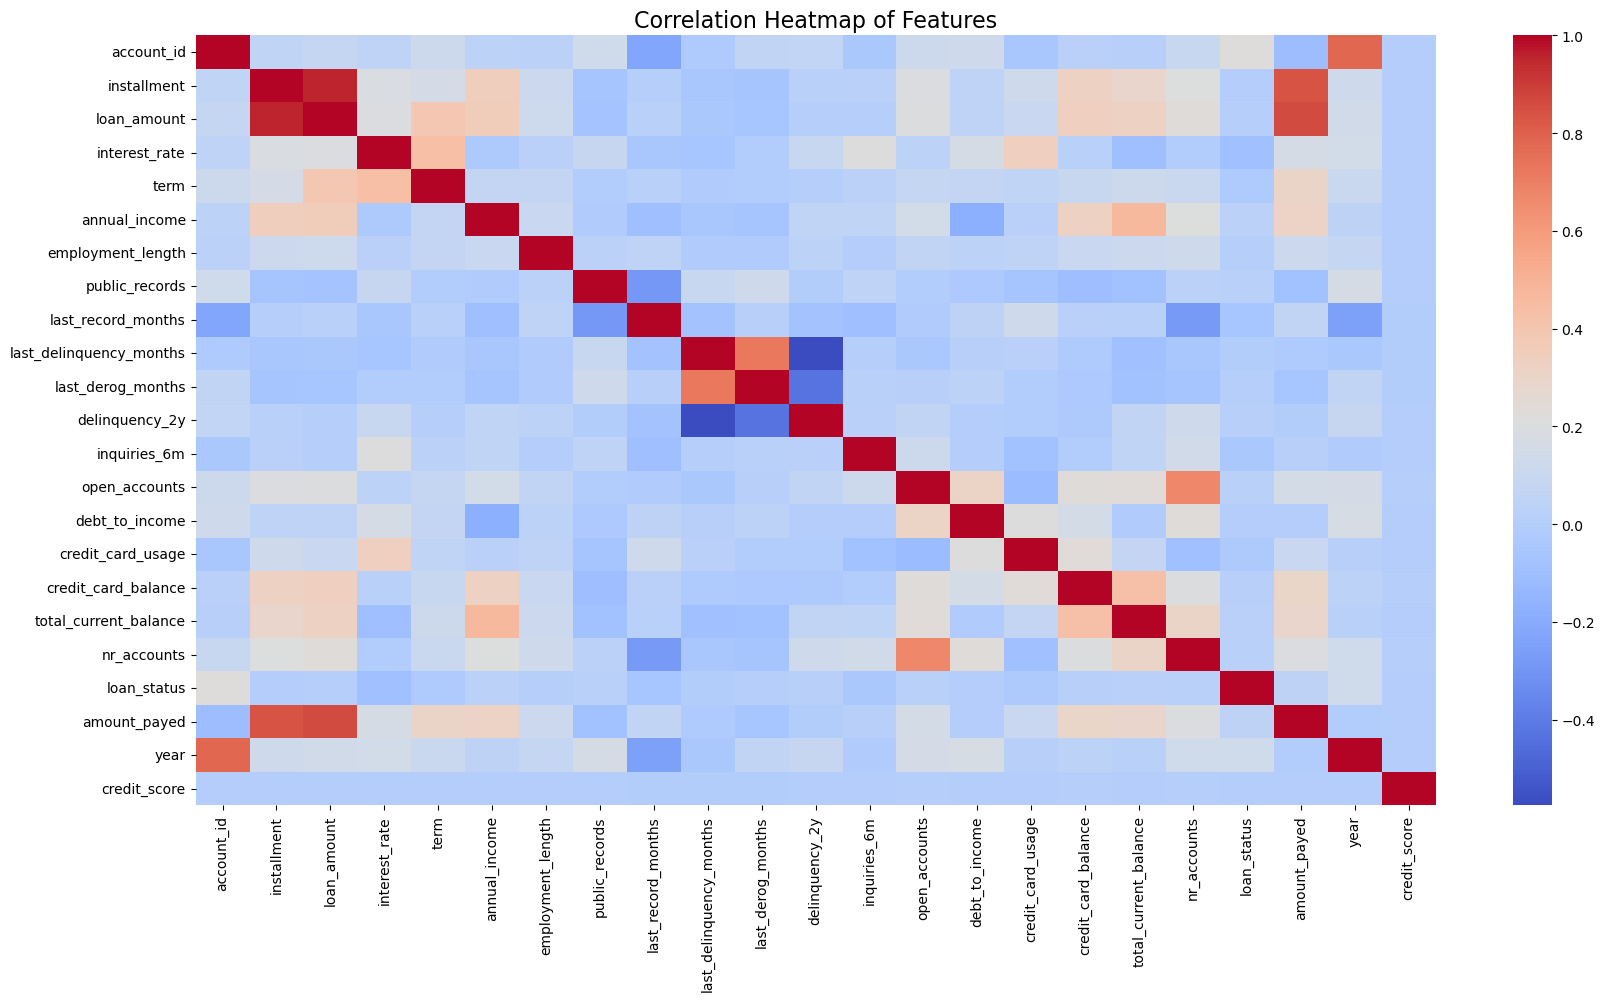

In [39]:
# Ensure target is numeric

loans['loan_status'], status_labels = pd.factorize(loans['loan_status'], sort=True)

# Compute correlation on numeric features only
corr = loans.corr(numeric_only=True)

plt.figure(figsize=(20,10))
sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=False,        # change to True if you want numbers
    fmt=".1f"
)
plt.title("Correlation Heatmap of Features", fontsize=16)
plt.show()


### Annual Income Distribution (Defaults)

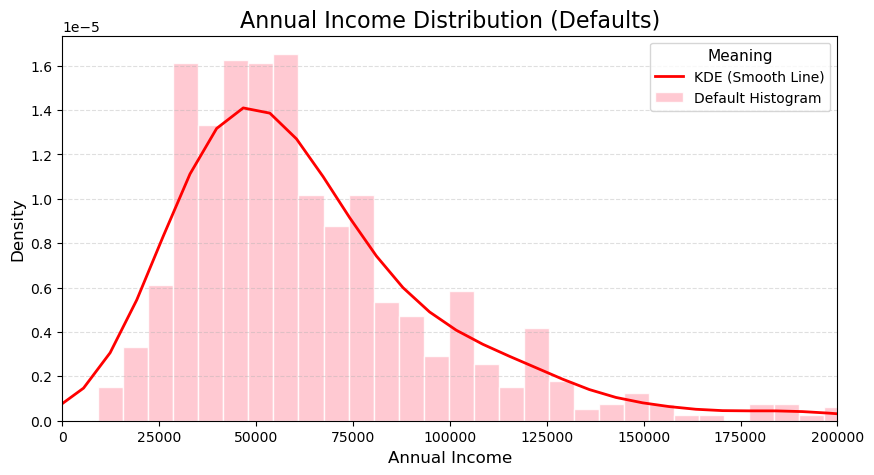

In [52]:
# Filter only defaults

default_income = loans.loc[loans['loan_status'] == 1, 'annual_income']

plt.figure(figsize=(10, 5))

# Histogram
plt.hist(
    default_income,
    bins=200,
    color="pink",
    edgecolor="white",
    alpha=0.85,
    density=True           # important for overlaying KDE correctly
)

# Smooth KDE line
sns.kdeplot(
    default_income,
    linewidth=2,
    color="red"
)

plt.title("Annual Income Distribution (Defaults)", fontsize=16)
plt.xlabel("Annual Income", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.xlim(0, 200000)

plt.legend(
    ["KDE (Smooth Line)", "Default Histogram"],
    title="Meaning",
    fontsize=10,
    title_fontsize=11
)

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


### Explore all scaled features by comparing distribution for Default vs Non-default

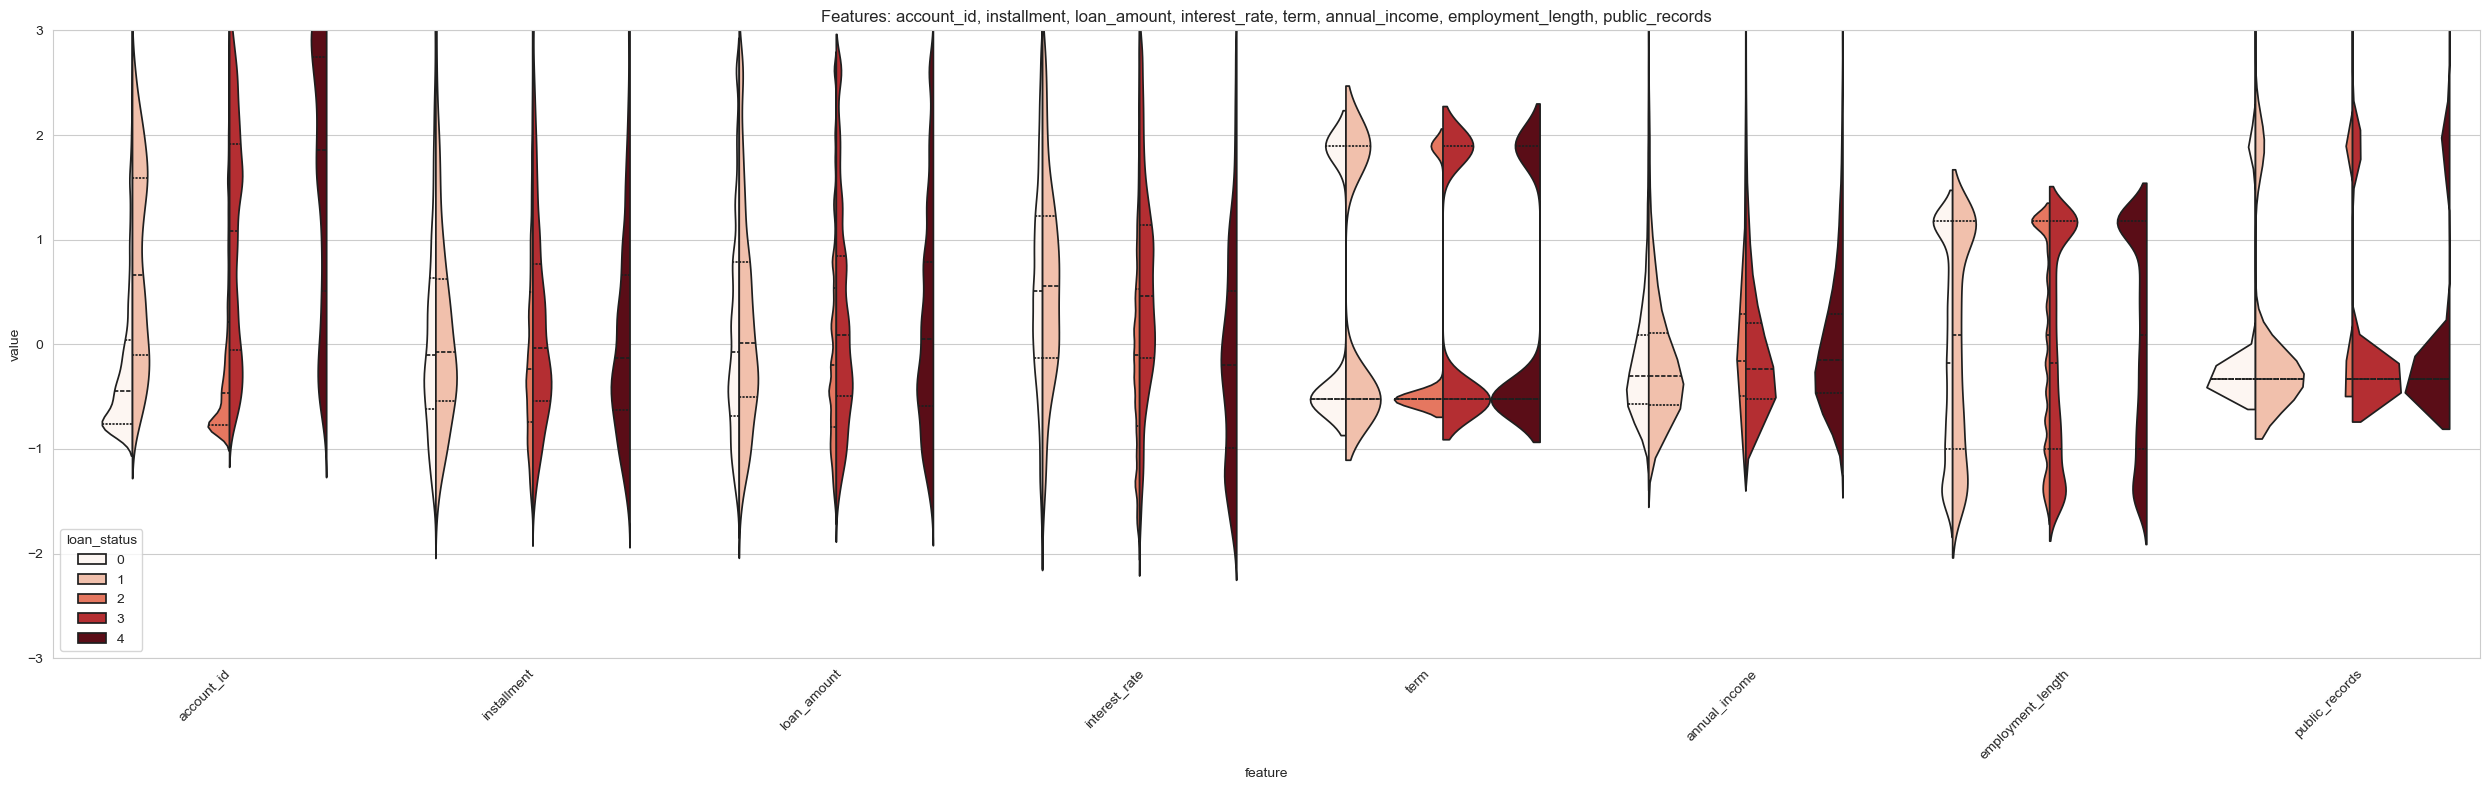

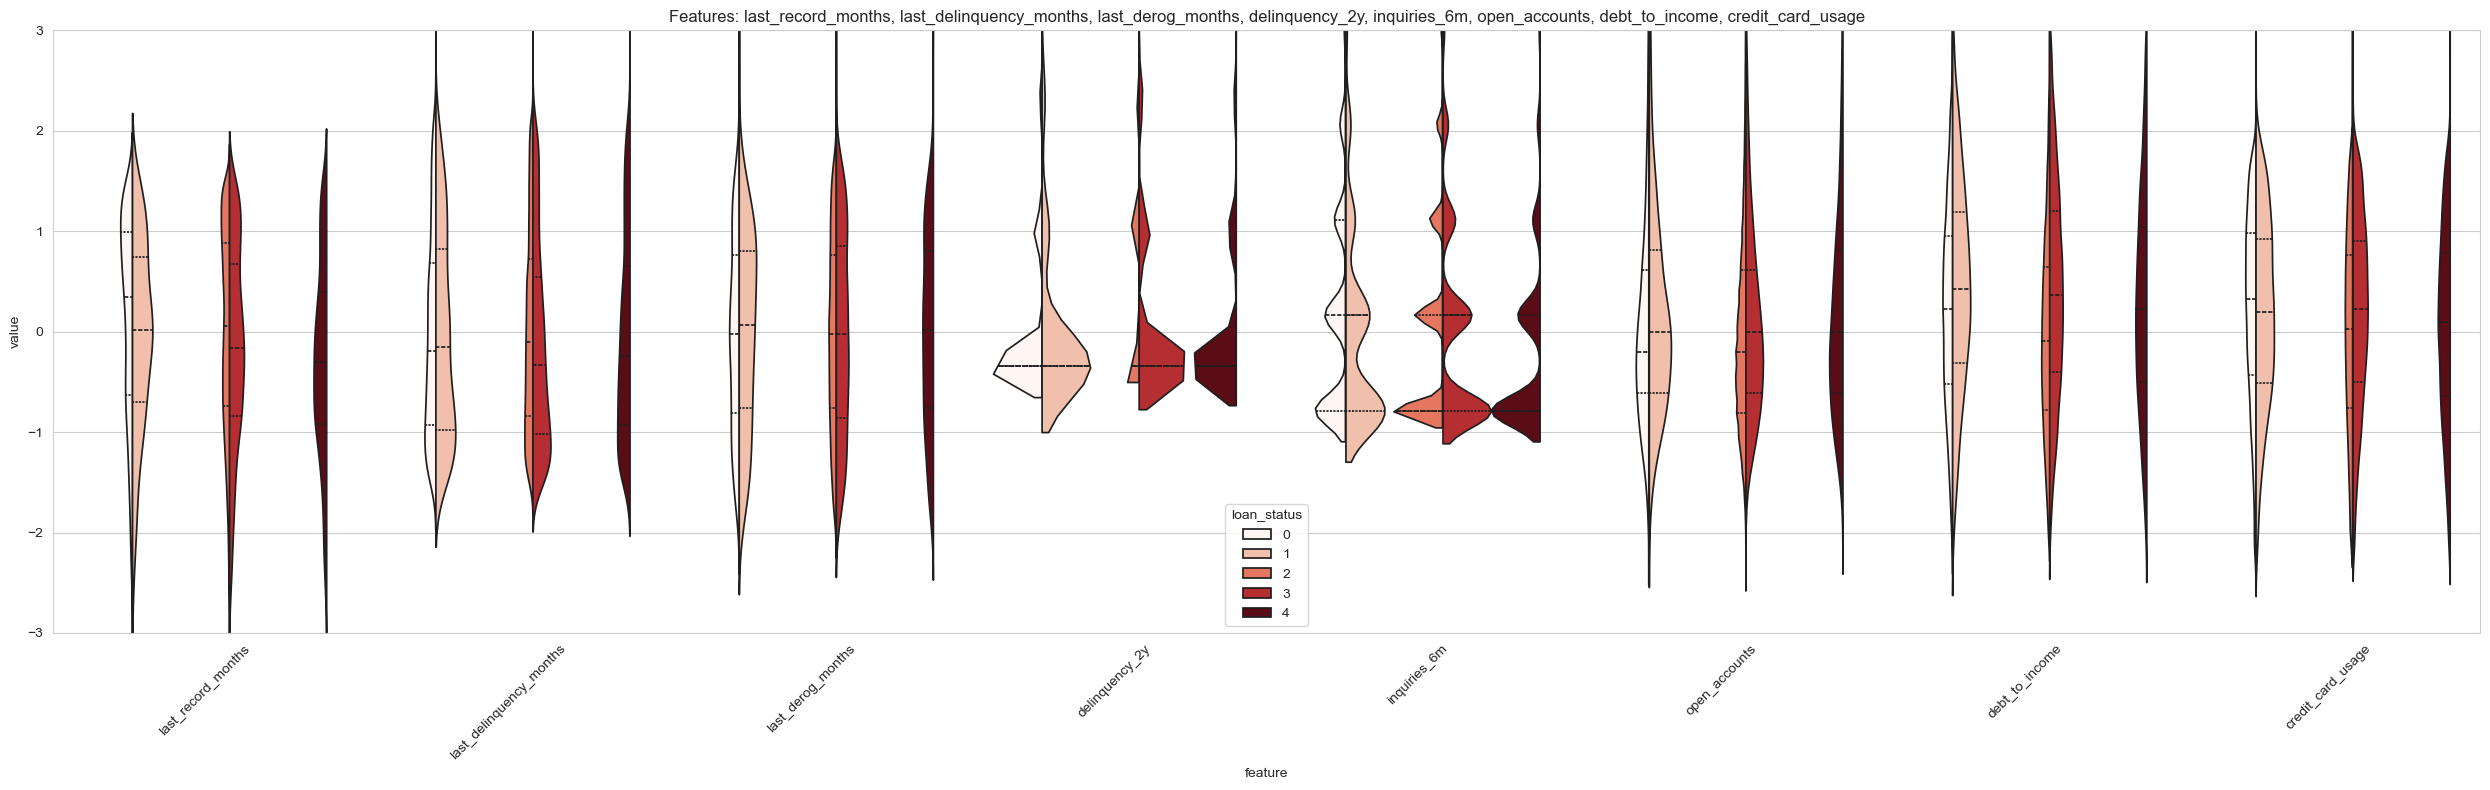

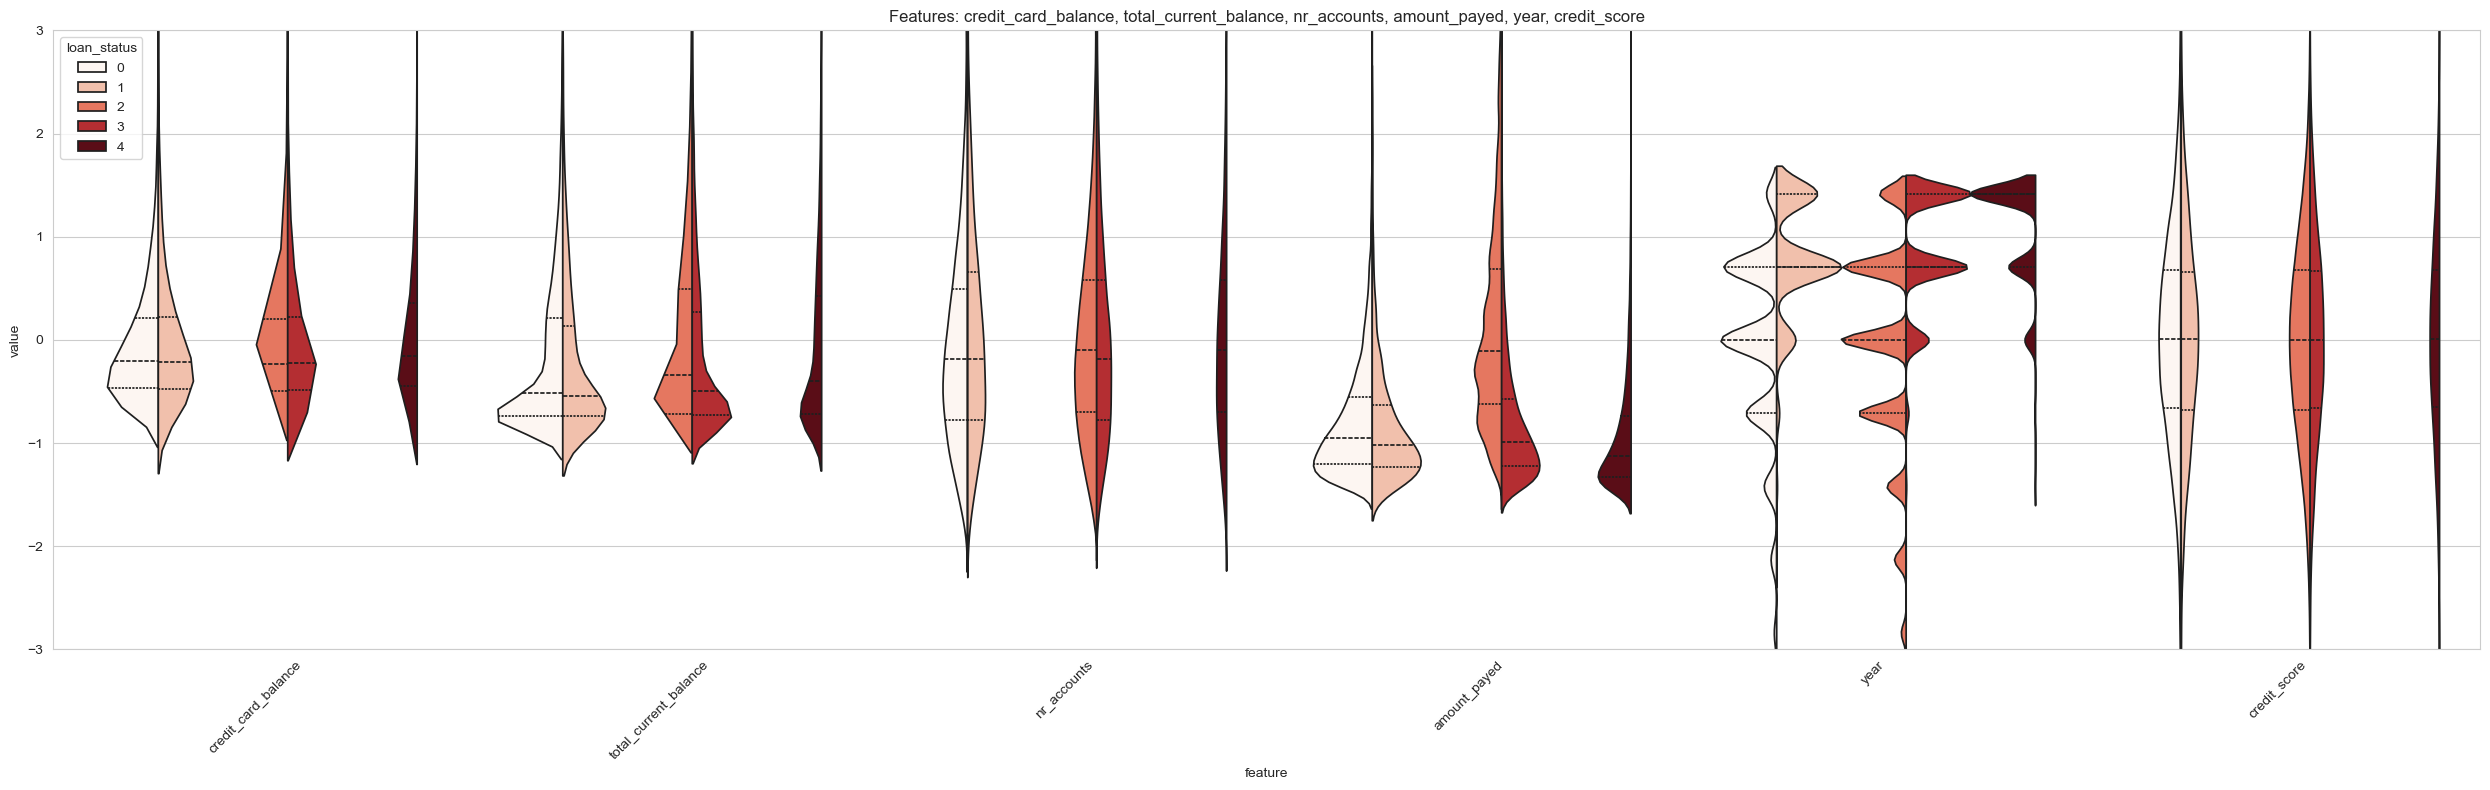

In [75]:
# Explore all scaled features by comparing distribution for Default vs Non-default

scaler = StandardScaler()
X_sc = scaler.fit_transform(X_numeric)

feature_groups = [X_numeric.columns[i:i+8] for i in range(0, len(X_numeric.columns), 8)]
for group in feature_groups:
    plt.figure(figsize=(25, 8))
    sns.violinplot(
        x='feature', y='value',
        hue='loan_status',
        data=stdX[stdX["feature"].isin(group)],
        split=True, inner='quart', palette='Reds'
    )
    plt.xticks(rotation=45)
    plt.title(f"Features: {', '.join(group)}")
    plt.ylim(-3, 3)
    plt.tight_layout()
    plt.show()



### Correlation of EachFeature with Default

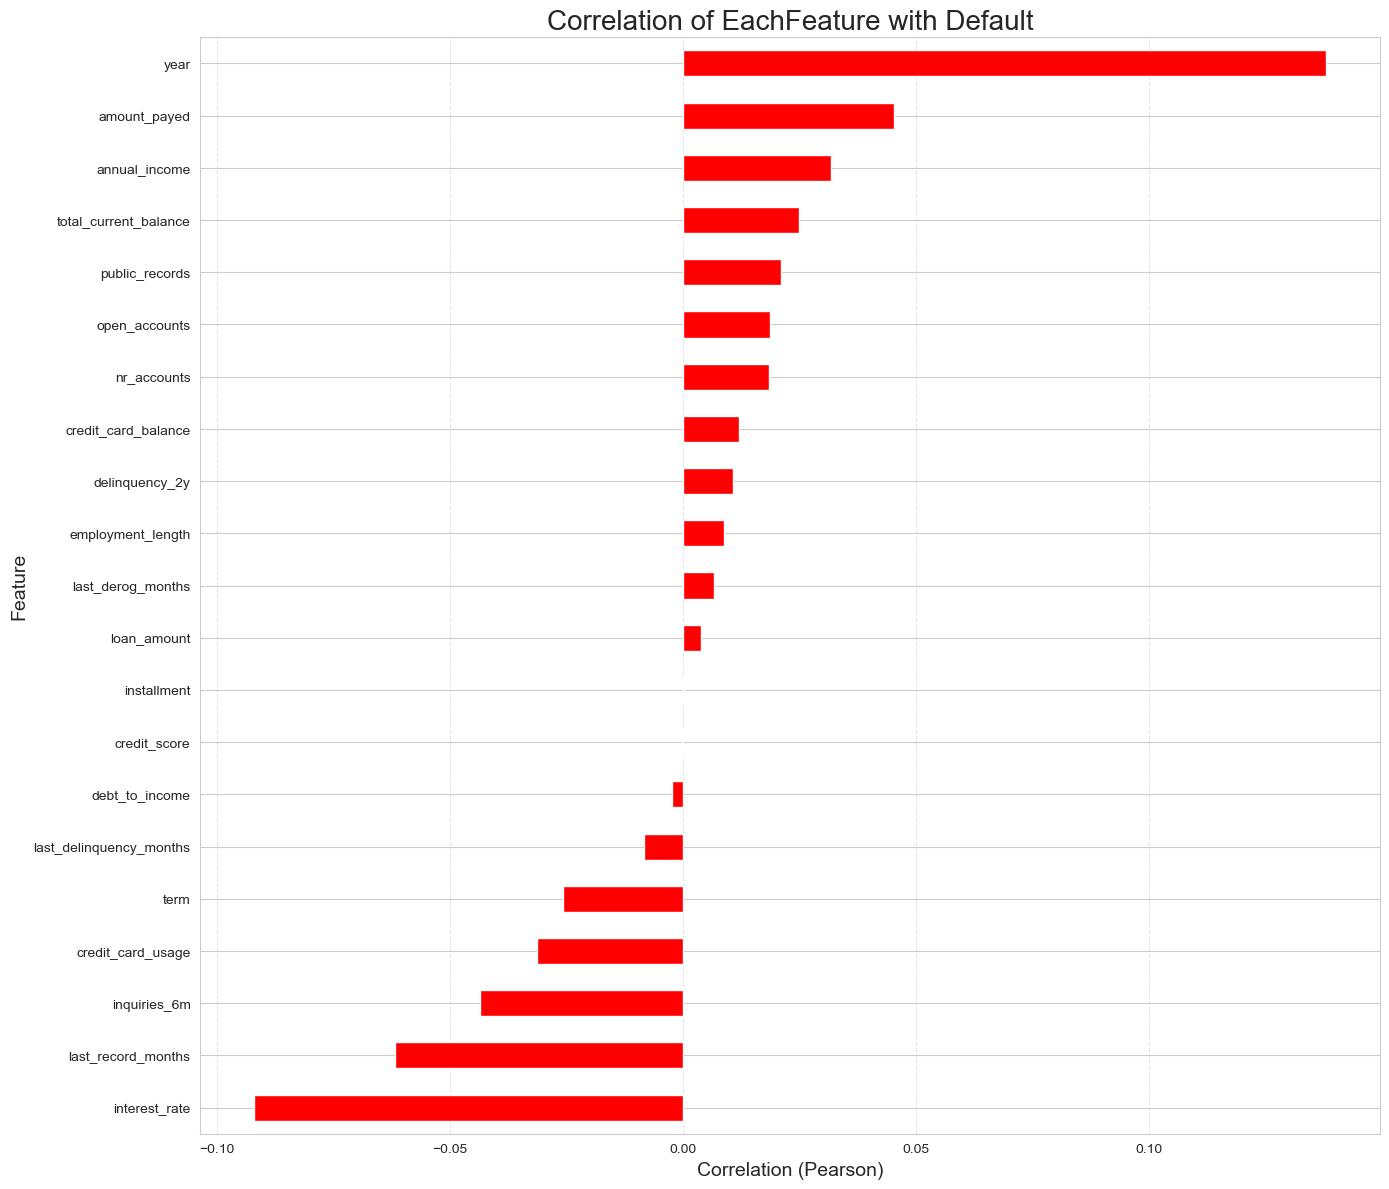

In [83]:
# Keep numeric columns only
numeric_df = loans.select_dtypes(include=[np.number])

# Remove account_id
if 'account_id' in numeric_df.columns:
    numeric_df = numeric_df.drop(columns=['account_id'])

# Define target + features
y = numeric_df['loan_status']
X = numeric_df.drop(columns=['loan_status'])

# Compute correlation (point-biserial = Pearson with binary)
corr_with_default = X.apply(lambda col: col.corr(y))

# Sort correlations
corr_with_default = corr_with_default.sort_values(ascending=True)

# Plot
plt.figure(figsize=(14, 12))
corr_with_default.plot(kind='barh', color='red')

plt.title("Correlation of EachFeature with Default", fontsize=20)
plt.xlabel("Correlation (Pearson)", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




### PCA 3D Plot Colored by Default

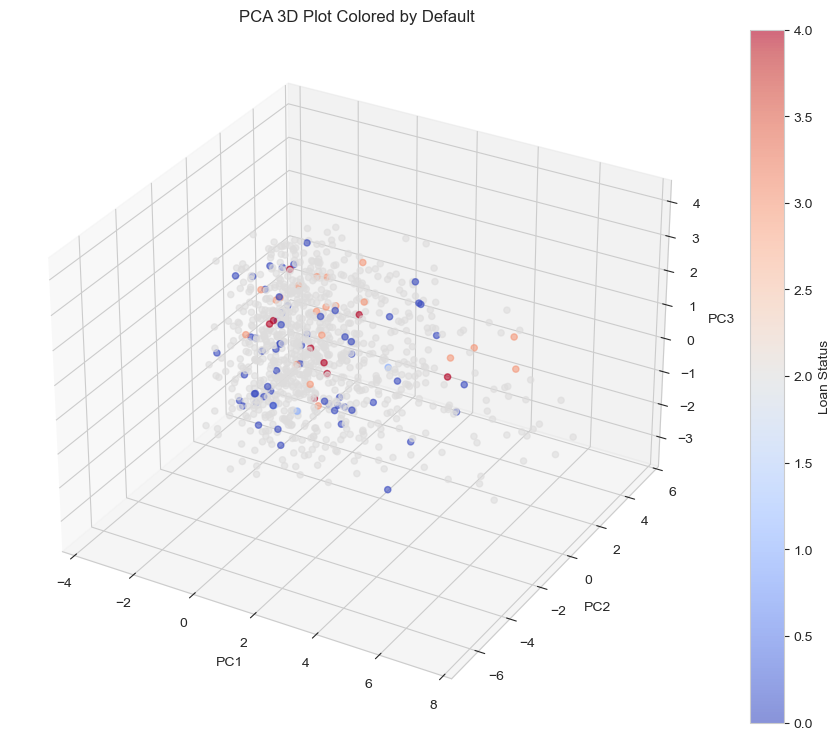

In [82]:
# Prepare the dataset
clean_df = loans.dropna()
X_numeric = clean_df.drop('loan_status', axis=1).select_dtypes(include=[np.number])
y = clean_df['loan_status']

# PCA
pca = PCA(n_components=3)
pcs = pca.fit_transform(X_sc)


# Plot
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(
    pcs[:,0], pcs[:,1], pcs[:,2],
    c=y,
    cmap="coolwarm",
    alpha=0.6
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA 3D Plot Colored by Default")

fig.colorbar(scatter, label="Loan Status")
plt.show()
